Exercise work consists of three parts. After each part, take the mini-exam available in Moodle. The questions concern the exercise so read the instructions carefully and make sure you remember to cover all given tasks. <br>
After the deadline of each mini-exam, example results will be published. This helps you to move to the next part. However, take into account that the deadlines are thus strict, no extensions will be granted! <br>
Two exam points can be acquired from each mini-exam. All three parts of the exercise are compulsory. Completed exercise work from previous years does not apply for this course.

**Deadlines for the mini-exams:**
- Part 1: Fri 9.2.2024 at 23:59
- Part 2: Fri 23.2024 at 23:59
- Part 3: Fri 8.3.2024 at 23:59

**If you encounter problems, Google first and if you can’t find an answer, ask for help**
- Moodle area for questions
- pekavir@utu.fi

**Grading**

The exercise covers a part of the grading in this course. The course exam has 5 questions, 6 points of each. Exercise gives at maximum 6 points, i.e. the total score is 36 points.

# Part 1

# Part 2

Import all the packages needed for this notebook in one cell (add the ones you apply):

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# import cv2 as cv
# import glob, os
import itertools
# from random import sample
# from random import seed
# from scipy.stats import skew
# from scipy.stats import kurtosis
# from scipy.stats import entropy
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Data exploration

Import the training data set prepared in the previous part of the exercise.

In [2]:
df = pd.read_parquet(
    '../training_data/rice_feature_data.parquet')

In [3]:
df.columns

Index(['mean_y', 'var_y', 'skew_y', 'kurt_y', 'mean_cr', 'var_cr', 'skew_cr',
       'kurt_cr', 'mean_cb', 'var_cb', 'skew_cb', 'kurt_cb',
       'major_axis_length', 'minor_axis_length', 'area', 'perimeter',
       'equivalent_diameter', 'compactness', 'shape_factor1', 'shape_factor2',
       'class', 'class_int'],
      dtype='object')

In [4]:
feats = [
    'mean_y', 'var_y', 'skew_y', 'kurt_y',
    'mean_cr', 'var_cr', 'skew_cr', 'kurt_cr',
    'mean_cb', 'var_cb', 'skew_cb', 'kurt_cb',
    'major_axis_length', 'minor_axis_length',
    'area', 'perimeter',
    'equivalent_diameter', 'compactness',
    'shape_factor1', 'shape_factor2']

Standardize the data using Z-score.

In [5]:
# Z-Score using pandas
for feat in feats:
    df['{}_Z'.format(feat)] = (
        df[feat] - df[feat].mean()) / df[feat].std()

In [6]:
# Z-scored feature names
feats_Z = [feat + '_Z' for feat in feats]

### Histograms

Plot a histogram for each Z-scored feature. Plot all rice species in the same figure and use different color for each.

In [7]:
len(feats_Z)

20

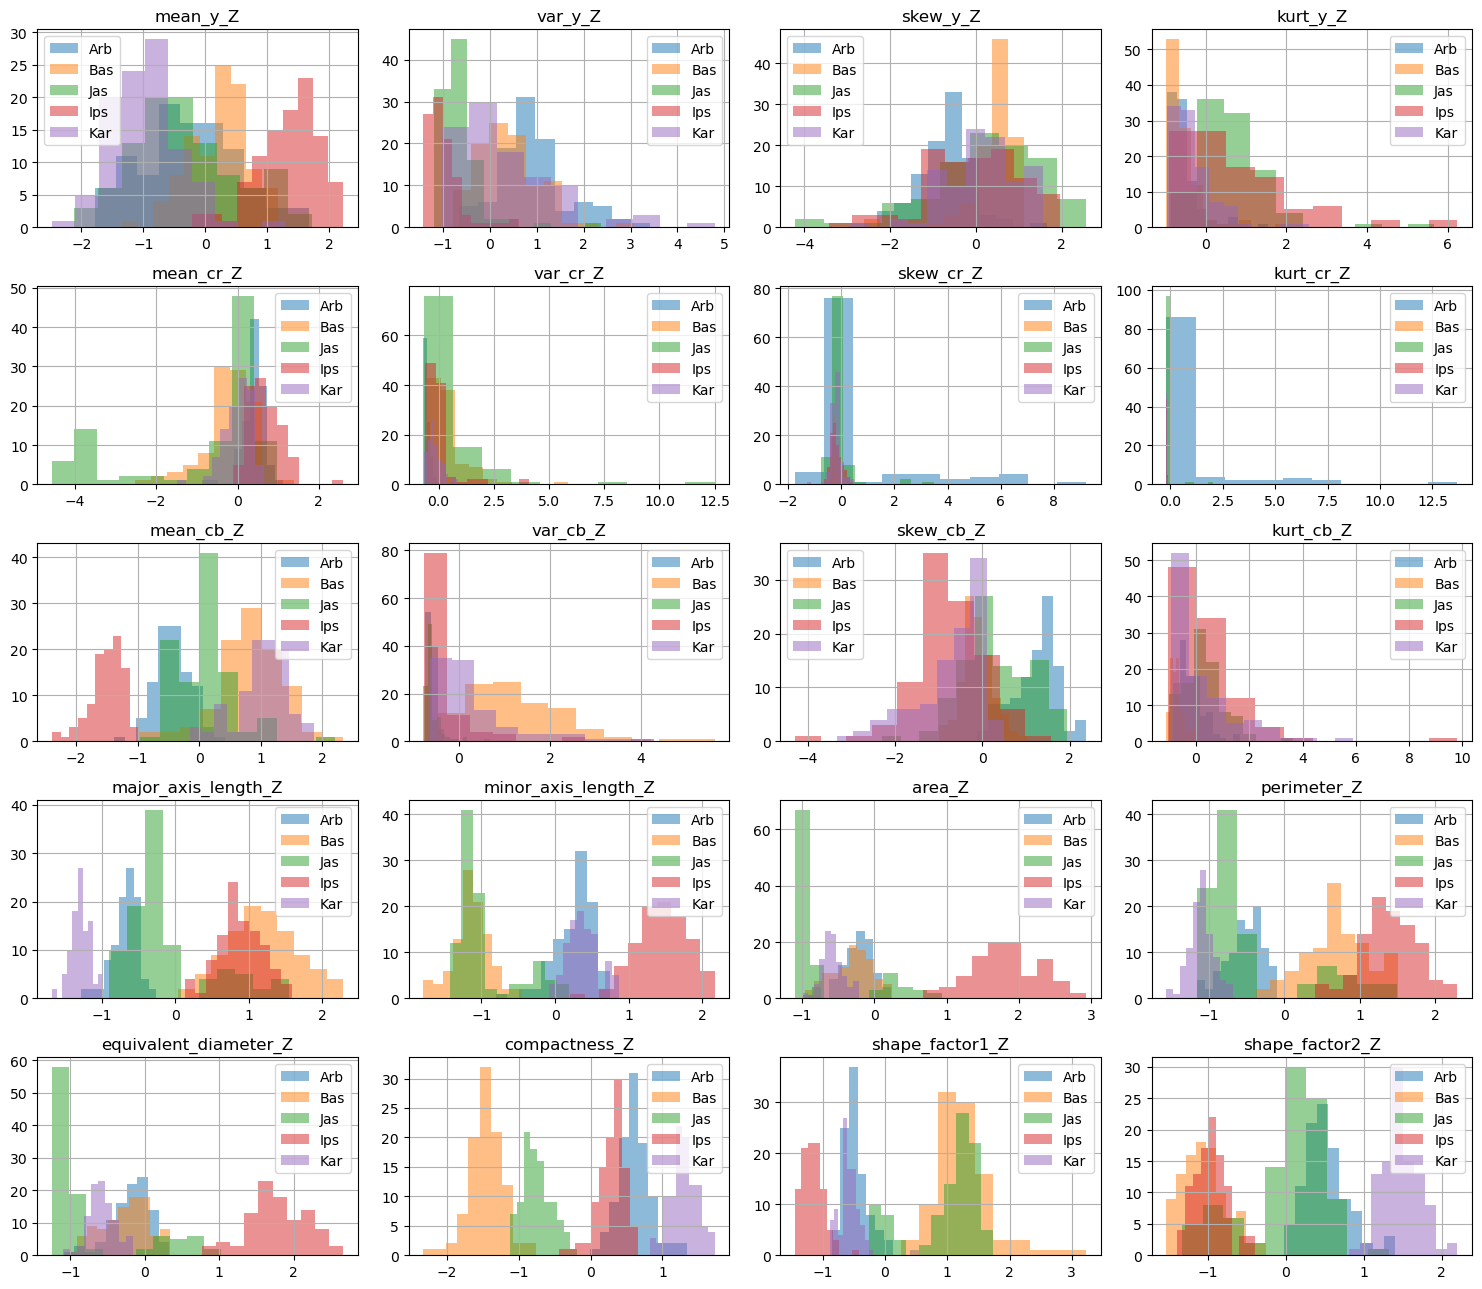

In [8]:
fig = plt.figure(figsize = (15,13))
for nr, feat in enumerate(feats_Z):
    plt.subplot(5, 4, nr + 1)
    for rice in ['Arb', 'Bas', 'Jas', 'Ips', 'Kar']:
        df[df['class'] == rice][feat].hist(alpha=0.5,
                                           label=rice)
    plt.title(feat)
    plt.legend()
plt.tight_layout()

Mini-exam question: <br>
**1. Which features may have some discriminative power over rice species according to the histograms?** <br>
Answer: Morphological and shape features

### Pairplot

Plot pairplots, each Z-scored feature against each Z-scored feature. Are there any correlating features according to the pairplot?

skew_cr_Z kurt_cr_Z 0.928
kurt_cr_Z skew_cr_Z 0.928
major_axis_length_Z perimeter_Z 0.919
major_axis_length_Z shape_factor2_Z -0.979
minor_axis_length_Z shape_factor1_Z -0.967
area_Z perimeter_Z 0.83
area_Z equivalent_diameter_Z 0.997
perimeter_Z major_axis_length_Z 0.919
perimeter_Z area_Z 0.83
perimeter_Z equivalent_diameter_Z 0.836
perimeter_Z shape_factor2_Z -0.917
equivalent_diameter_Z area_Z 0.997
equivalent_diameter_Z perimeter_Z 0.836
compactness_Z shape_factor1_Z -0.822
shape_factor1_Z minor_axis_length_Z -0.967
shape_factor1_Z compactness_Z -0.822
shape_factor2_Z major_axis_length_Z -0.979
shape_factor2_Z perimeter_Z -0.917


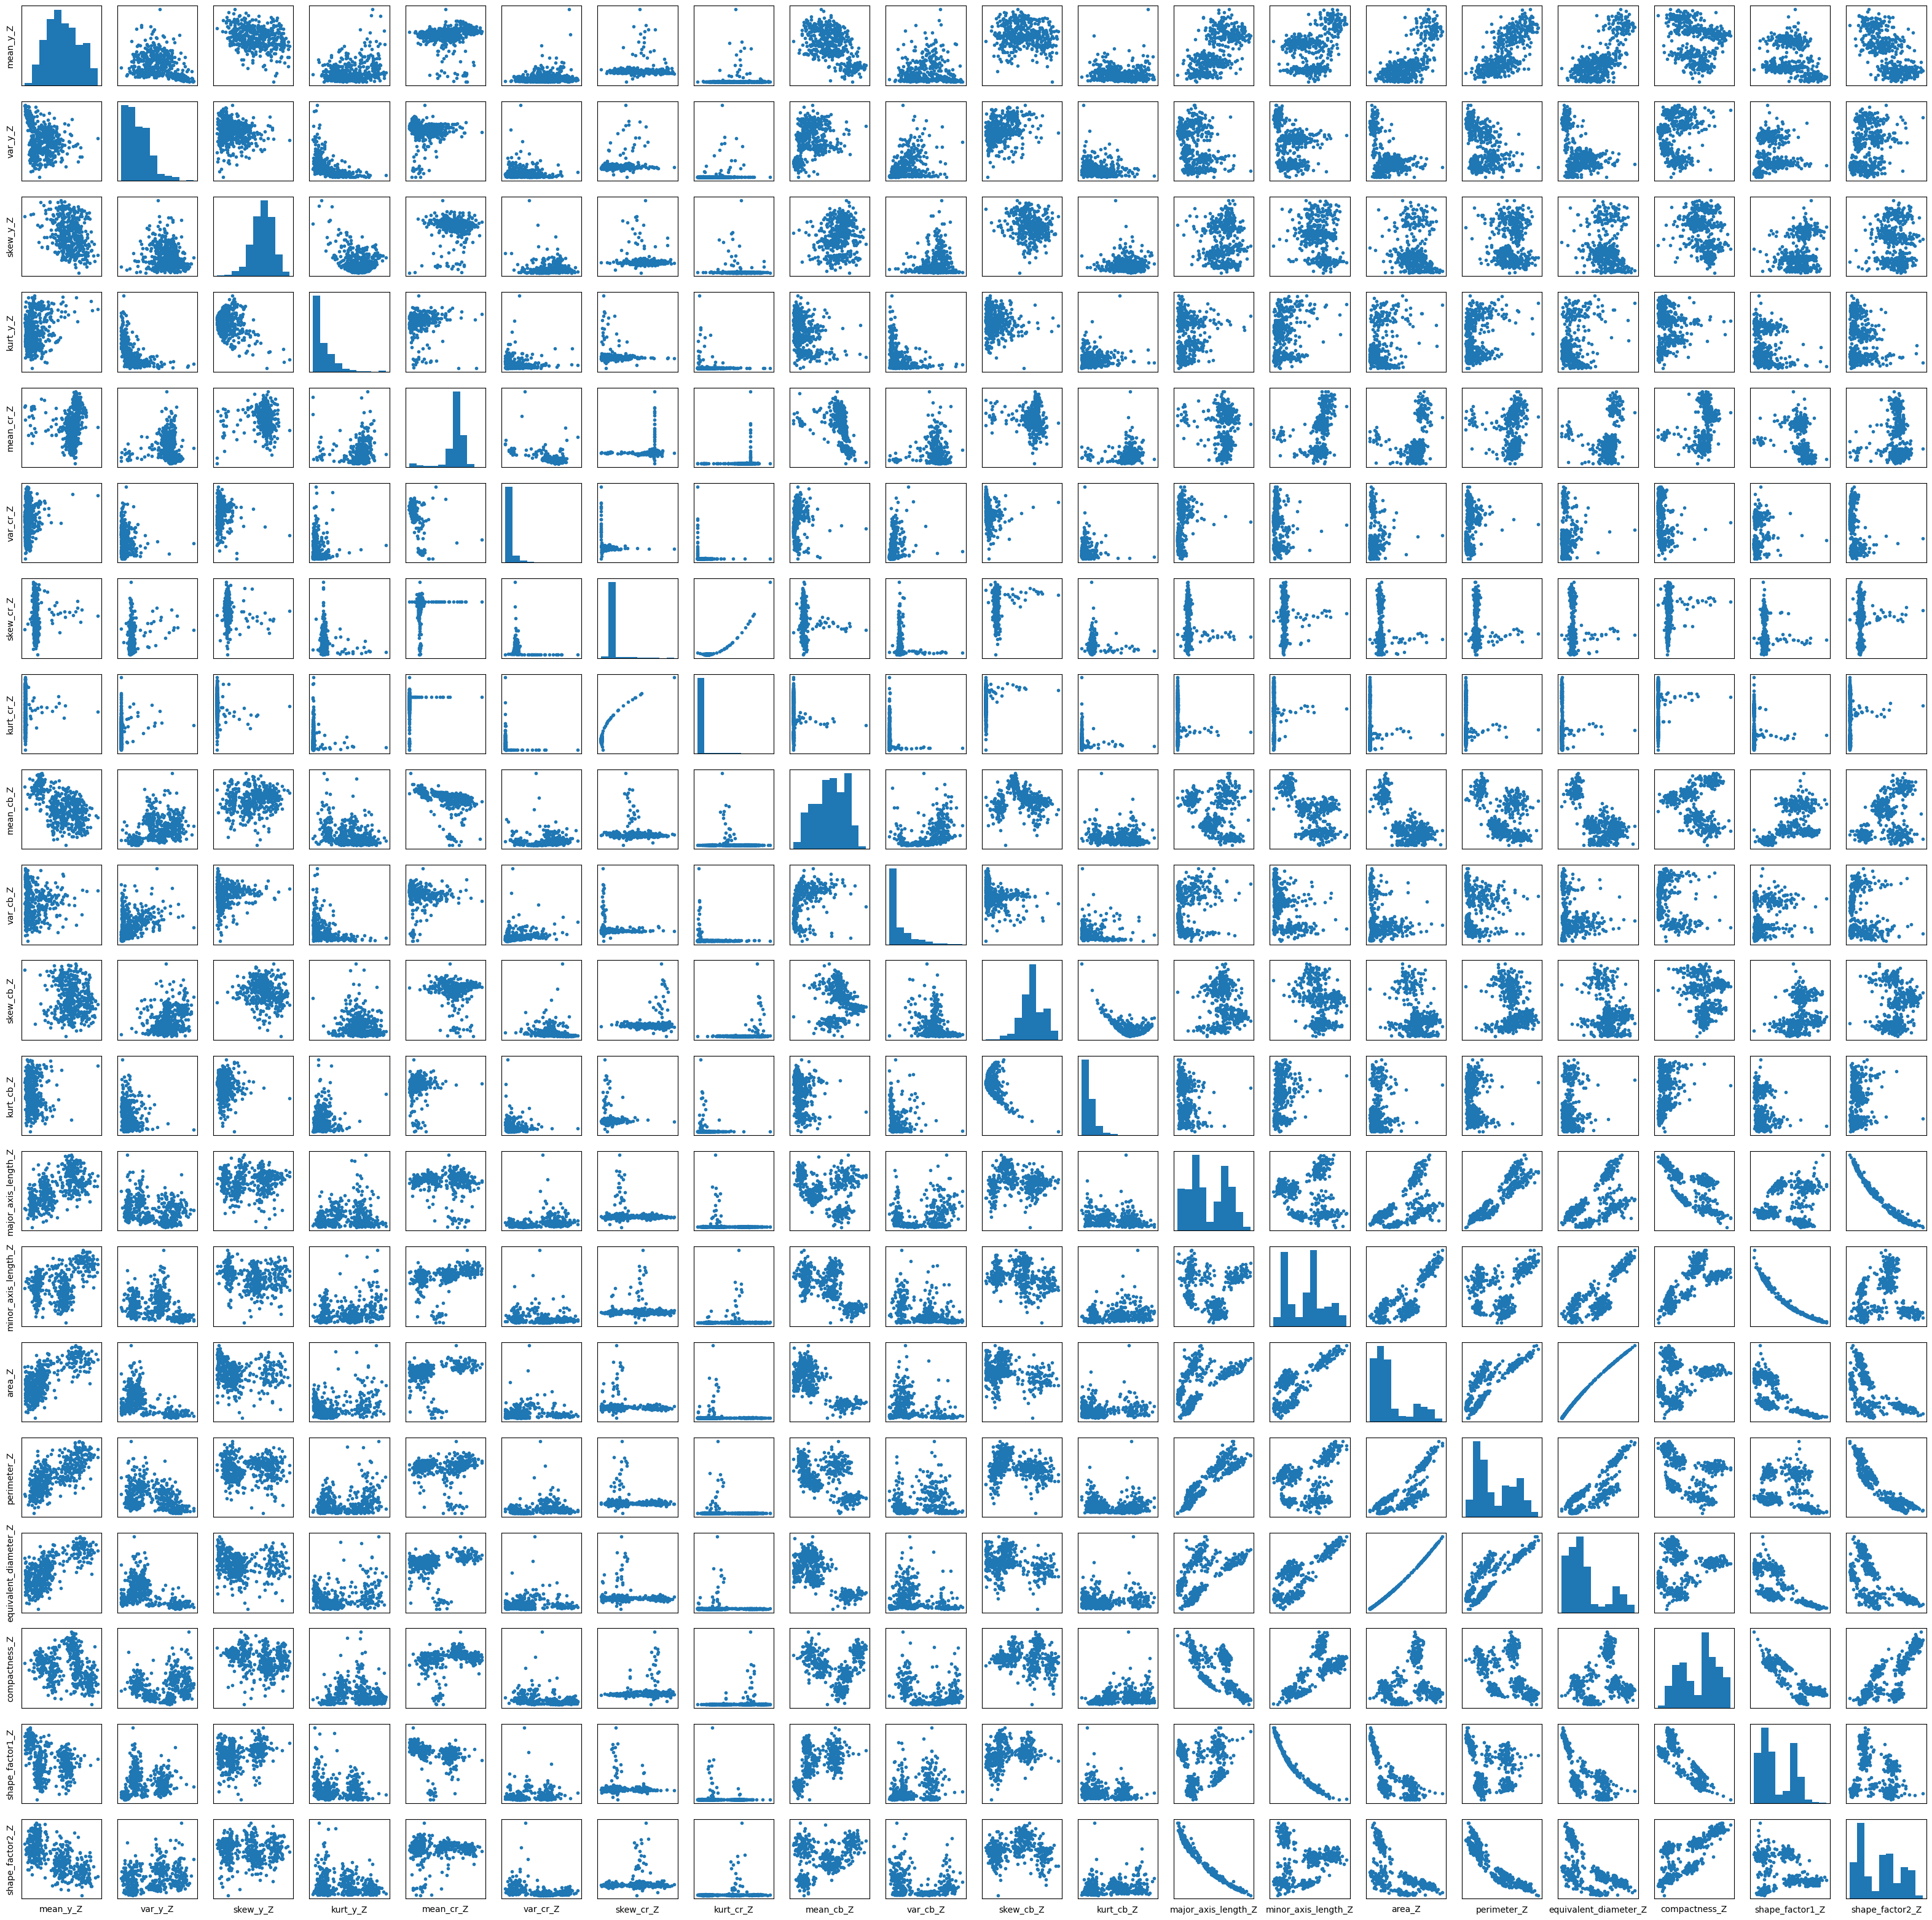

In [9]:
feat_comb = list(itertools.product(feats_Z, feats_Z))
rc = int(np.sqrt(len(feat_comb)))
plt.figure(figsize = (rc*2, rc*2))

i = 0
for f1, f2 in feat_comb:
    i += 1
    plt.subplot(rc, rc, i)
    if f1 == f2:
        plt.hist(df[f1])
    else:
        plt.plot(df[f1], df[f2], '.')
    if i%rc == 1:
        plt.ylabel(f1)
    if i in range((rc-1)*rc+1, (rc*rc)+1):
        plt.xlabel(f2)
    
    # print features if their absolute Pearson
    # correlation coefficient > 0.8 (~strong correlation)
    if (f1 != f2) & (
        abs(scipy.stats.pearsonr(
            df[f1].values,
            df[f2].values)[0]) > 0.8):
        
        print(f1, f2,
              np.round(
                  scipy.stats.pearsonr(
                      df[f1].values,
                      df[f2].values)[0], 3))
    plt.xticks([])
    plt.yticks([])
    
plt.savefig('pairplot.png', dpi=200)

Mini-exam question: <br>
**2. Which features seem to strongly correlate with each other?** <br>
Answer: Area and equivalent diameter

### PCA

Fit PCA using two principal components (remember to use Z-scored feature values). <br>
Plot the PCA figure with two components, and color the data points according to their species. <br>
Show the legend and label the axes.
Save the figure as a png-file.

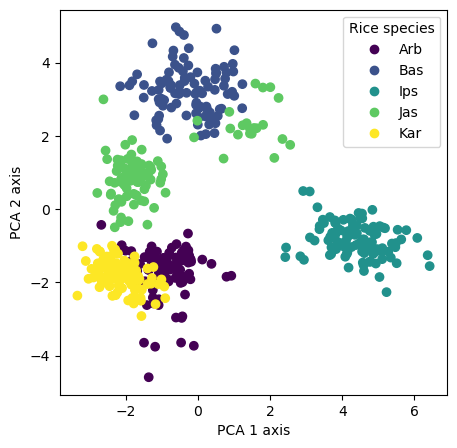

In [10]:
plt.figure(figsize=(5,5))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df[feats_Z].values)

scat = plt.scatter(X_pca[:,0],
                   X_pca[:,1],
                   c=df['class_int'])

sp_names = list(df['class'].unique())
plt.legend(handles=scat.legend_elements()[0],
           labels=sp_names,
           title="Rice species")
plt.xlabel('PCA 1 axis')
plt.ylabel('PCA 2 axis')
plt.savefig('pca.png', dpi=200);

In [11]:
pca= PCA(.97)
principalComponents = pca.fit_transform(df[feats_Z].values)
print(pca.n_components_, 'components are needed to cover 97% of the variance')

11 components are needed to cover 97% of the variance


Mini-exam question:<br>
**3.** <br>
**Return your PCA figure as png-file.** <br>
Answer: All requirements met --> 1 point
 - axes labeled
 - classes drawn with different colors
 - legend shown
 - Z-scored values used
 - figure returned as a png-file
 - the drawn data seems appropiate

**Can you see any clusters in the PCA figure? Does this figure give you any clues, how well you will be able to classify the image types? Explain.** <br>
Answer: There are distinct clusters seen in the PCA with two principal components, which means that the deployed features hold useful information. Ipsala is clearly separable from the other rice species. Arborio and Karacadag somewhat overlap, as well as Jasmine and Basmati. <br>
Jasmine has two clusters. This was also seen in the histograms of morphological and shape features for Jasmine, as all but compactness were bimodal. <br>
Here we have only two principal components. This does not mean that we cannot train a well-performing classifier, but there may be more confusions with Arborio/Karacadag and Jasmine/Basmati. <br>
<br>
**How many PCA components are needed to cover 97% of the variance?** <br>
Answer: 11 components

## Model selection (2 p)

Perform model selection for each classifier. Use 5-fold repeated cross validation with 3 repetitions (*RepeatedKFold* from sklearn). Use the following hyperparameters:

- Random Forest
    - n_estimators from 100 to 300 with 50 steps
    - max_features = ['sqrt', 'log2', None]
    - whether to use bootstrap or not 

- Support Vector Machine
    - gamma = ['scale', 'auto']
    - C = [0.1, 1, 10, 100]
    - kernel = ['linear', 'rbf', 'poly']
    
- MLP:
    - use one hidden layer
    - number of neurons in the hidden layer from 15 to 40 in 5 neuron steps
    - activation function: hyperbolic tanh function and rectified linear unit function
    - solver: stochastic gradient descent and adam
    - validation_fraction: 0.1 and 0.3
    - strength of the L2 regularization term: alpha = [0.01, 0.1, 1]

For each classifier:
- Report the selected combination of hyperparameters <br>
- Report the accuracy value for each hyperparameter combination <br>

For Random Forest model, report the feature importance for each feature. Which features seem to be the most important? Does this correspond with the observations you made in the data exploration? <br>
Ponder the model selection process. Which things should be considered? How could you improve the model selection process?

In [12]:
y = df['class'].values
X = df[feats_Z].values

### Random forest

In [13]:
n_estimators = range(100, 350, 50) 
max_features = ['sqrt', 'log2', None]
bootstrap = [True, False]

parameters={'n_estimators': n_estimators,
           'max_features': max_features,
            'bootstrap': bootstrap}

clf = RandomForestClassifier(random_state=20)
kf = RepeatedKFold(n_splits=5,
                   n_repeats=3,
                   random_state=5)

gscv = GridSearchCV(clf,
                    parameters,
                    cv=kf,
                    return_train_score=False,
                    n_jobs=-1)
gscv.fit(X,y)
print('Best hyperparameter combination:')
print('n_estimators:', gscv.best_params_['n_estimators'])
print('max_features:', gscv.best_params_['max_features'])
print('bootstrap:', gscv.best_params_['bootstrap'])

Best hyperparameter combination:
n_estimators: 250
max_features: sqrt
bootstrap: False


In [14]:
for par, score in zip(gscv.cv_results_['params'],
                      gscv.cv_results_['mean_test_score']):
    print(par, np.round(score,3))

{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100} 0.99
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 150} 0.991
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200} 0.988
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 250} 0.989
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 300} 0.99
{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 100} 0.99
{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 150} 0.991
{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 200} 0.988
{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 250} 0.989
{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 300} 0.99
{'bootstrap': True, 'max_features': None, 'n_estimators': 100} 0.987
{'bootstrap': True, 'max_features': None, 'n_estimators': 150} 0.989
{'bootstrap': True, 'max_features': None, 'n_estimators': 200} 0.988
{'bootstrap': True, 'max_features': None, 'n_estimators': 250} 0.987
{'bootstrap': True

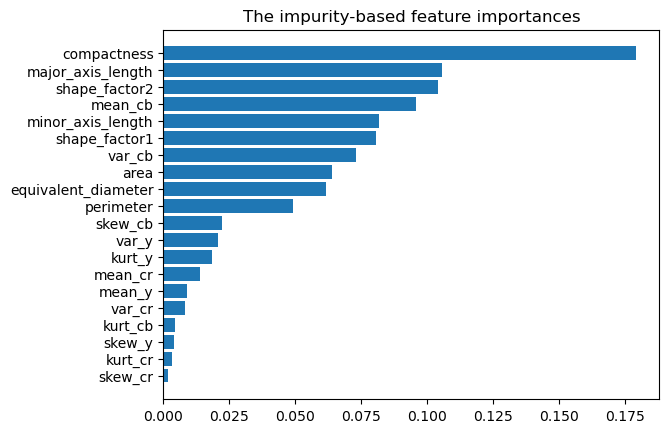

In [15]:
# Feature importance for each feature
y_pos = np.arange(len(feats))
fig, ax = plt.subplots()
ind = np.argsort(gscv.best_estimator_.feature_importances_)

ax.barh(y_pos,
        np.flip(gscv.best_estimator_.feature_importances_[ind]),
        align='center')
ax.set_yticks(y_pos, labels=np.flip(np.array(feats)[ind]))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('The impurity-based feature importances');

Mini-exam question:<br>
**4. Which features seem to be the most important according to the Random Forest model? Does this correspond with the observations you made in the data exploration?**<br>
Answer: According to the feature importance results, in general, the morphological and the shape features seem to be more beneficial. <br>
Compactness seems to be the most beneficial feature. <br>
This was expectable according to the findings from the histograms, where morphological and shape features seemed to have distributions with less class overlap than other features.

### Support Vector Machine SVM

In [16]:
gamma = ['scale', 'auto']
C = [0.1, 1, 10, 100]
kernel = ['linear', 'rbf', 'poly']

parameters = {'C': C,
              'gamma': gamma,
             'kernel': kernel}

svm = SVC()
kf = RepeatedKFold(n_splits=5,
                   n_repeats=3,
                   random_state=5)

gscv = GridSearchCV(svm,
                    parameters,
                    cv=kf,
                    return_train_score=False,
                    n_jobs=-1)
gscv.fit(X,y)
print('Best hyperparameter combination:')
print('gamma:', gscv.best_params_['gamma'])
print('C:', gscv.best_params_['C'])
print('kernel:', gscv.best_params_['kernel'])

Best hyperparameter combination:
gamma: scale
C: 0.1
kernel: linear


In [17]:
for par, score in zip(gscv.cv_results_['params'],
                      gscv.cv_results_['mean_test_score']):
    print(par, np.round(score,3))

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'} 0.998
{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} 0.981
{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'} 0.901
{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'} 0.998
{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'} 0.981
{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'} 0.895
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'} 0.995
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} 0.991
{'C': 1, 'gamma': 'scale', 'kernel': 'poly'} 0.977
{'C': 1, 'gamma': 'auto', 'kernel': 'linear'} 0.995
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'} 0.991
{'C': 1, 'gamma': 'auto', 'kernel': 'poly'} 0.977
{'C': 10, 'gamma': 'scale', 'kernel': 'linear'} 0.994
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} 0.992
{'C': 10, 'gamma': 'scale', 'kernel': 'poly'} 0.993
{'C': 10, 'gamma': 'auto', 'kernel': 'linear'} 0.994
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'} 0.992
{'C': 10, 'gamma': 'auto', 'kernel': 'poly'} 0.993
{'C': 100, 'gamma': 'scale', 'kernel': 'linear'} 0.994
{'C': 100, '

### MLP

In [18]:
import time
start_time = time.time()
mlp = MLPClassifier(random_state=20)

hidden_layer_sizes = [
    (i,) for i in range(15, 45, 5)]
activation = ['tanh', 'relu']
solver = ['sgd', 'adam']
val_fr = [0.1, 0.3]
alpha = [0.01, 0.1, 1]

parameter_space = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'activation': activation,
    'solver': solver,
    'validation_fraction': val_fr,
    'alpha': alpha
}

kf = RepeatedKFold(n_splits=5,
                   n_repeats=3,
                   random_state=5)

# select the best hyperparameter set
gscv = GridSearchCV(mlp,
                    parameter_space,
                    cv=kf,
                    n_jobs=-1)
gscv.fit(X, y)
print('Best hyperparameter combination:')
print(gscv.best_params_)
    
print("--- %s seconds ---" % (time.time() - start_time))

Best hyperparameter combination:
{'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (25,), 'solver': 'adam', 'validation_fraction': 0.1}
--- 124.69005823135376 seconds ---


C:\Users\pekavir\Miniconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
gscv.best_params_

{'activation': 'relu',
 'alpha': 1,
 'hidden_layer_sizes': (25,),
 'solver': 'adam',
 'validation_fraction': 0.1}

In [20]:
for par, score in zip(gscv.cv_results_['params'],
                      gscv.cv_results_['mean_test_score']):
    print(par, np.round(score,3))

{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15,), 'solver': 'sgd', 'validation_fraction': 0.1} 0.968
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15,), 'solver': 'sgd', 'validation_fraction': 0.3} 0.968
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15,), 'solver': 'adam', 'validation_fraction': 0.1} 0.98
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15,), 'solver': 'adam', 'validation_fraction': 0.3} 0.98
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (20,), 'solver': 'sgd', 'validation_fraction': 0.1} 0.976
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (20,), 'solver': 'sgd', 'validation_fraction': 0.3} 0.976
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (20,), 'solver': 'adam', 'validation_fraction': 0.1} 0.985
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (20,), 'solver': 'adam', 'validation_fraction': 0.3} 0.985
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_si

Mini-exam question: <br>
**5. Ponder the model selection process. Which things should be considered? How could you improve the process?** <br>
- Class imbalance is not a problem in this particular case as each species has 100 samples, however, in general case it should be taken into account
- Repeated KFold was used, however only three repetitions were used. There is probably some variation in the selected hyperparameter combinations depending on the used split. A larger number of repetitions could be used. For this data size, leave-one-out is not feasible
- Only selected parameters were tuned with a few options, tuning also other parameters/larger parameter space might improve the result. However, increasing the number of hyperparameters increases the number of combinations to be studied, which increases the computation time if we're using exhaustive grid search. Randomized seach could be applied if several combinations are studied
- Dimensionality reduction was not used, but the original features were used as such. PCA components could be used as features to suppress redundant information
- Other machine learning models could be tested as well
- Other performance estimators could be tested. Now we used only accuracy. Especially in cases where there is class imbalance, it is important to take this into account
- The data size was not very large. With large data sets it is important to choose scalable models and consider the computational resources as well

Mini-exam question: <br>
**6. Which of the models seems to benefit the most of the hyperparameter tuning (with these parameter combinations)?** <br>
Answer: I found an error in my own implementation. I used early_stopping = True, whereas this was not specified in the instructions. When having early_stopping = True, MLP gets really poor performance for some parameter combinations, so it seems that MLP benefits the most of parameter tuning. You'll get 1 point as long as you have answered something to this question! 